In [2]:
import pandas as pd
import os
import git
import numpy as np

def get_git_root(path):

        git_repo = git.Repo(path, search_parent_directories=True)
        #git_root = git_repo.git.rev_parse("--show-toplevel")
        
        return git_repo.working_dir

In [3]:
top_level_git_dir = get_git_root(os.getcwd())
raw_data_dir = os.path.join(top_level_git_dir, "data", "raw")

train_csv_path = os.path.join(raw_data_dir, "train_values.csv")
test_csv_path = os.path.join(raw_data_dir, "test_values.csv")
train_labels_csv_path = os.path.join(raw_data_dir, "train_labels.csv")
submission_format_csv_path = os.path.join(raw_data_dir, "submission_format.csv")

train_df = pd.read_csv(train_csv_path, index_col = "row_id")
train_labels_df = pd.read_csv(train_labels_csv_path, index_col = "process_id")
test_df = pd.read_csv(test_csv_path, index_col = "row_id")
submission_format_csv_path = pd.read_csv(submission_format_csv_path, index_col = "process_id")


/Users/greg.bolla/.local/share/virtualenvs/driven-data-rinse-over-run-w5STMFPe/lib/python3.6/site-packages/numpy/lib/arraysetops.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
response_dict = {}
for proc_id in train_df.process_id.unique():
    final_phase_for_proc = train_df[(train_df.process_id == proc_id) & (train_df.target_time_period == True)]
    final_phase_for_proc = final_phase_for_proc.assign(final_phase_turbidity = \
        np.maximum(0, final_phase_for_proc.return_flow) * final_phase_for_proc.return_turbidity)
    proc_id_response = final_phase_for_proc["final_phase_turbidity"].sum()
    
    response_dict[proc_id] = proc_id_response

In [5]:
response_dict

{20001: 4318275.12554818,
 20002: 437528.57109794125,
 20003: 427197.73393308267,
 20004: 719783.0261053684,
 20005: 413310.6503749337,
 20008: 4100847.0864118547,
 20011: 3058669.195203994,
 20014: 2706871.4373974237,
 20016: 521755.33349069883,
 20017: 103724.28729467509,
 20018: 1366681.8465563094,
 20019: 53408.509967789665,
 20023: 1875568.3397814478,
 20025: 327966.6135227812,
 20030: 508890.15811140987,
 20033: 668203.1933072086,
 20035: 433945.2282390981,
 20037: 314885.3107635207,
 20039: 1763055.4335154223,
 20042: 689355.9961675403,
 20043: 1585300.1251132558,
 20044: 349528.2890806126,
 20045: 983082.6895779017,
 20046: 1079254.346558409,
 20047: 326358.14896491176,
 20049: 660466.9393707704,
 20050: 553740.272660489,
 20051: 59006.66805360914,
 20053: 1707946.5172790927,
 20057: 758868.590742599,
 20058: 58417.41697918879,
 20062: 589065.7840487394,
 20065: 692860.5903703257,
 20066: 557125.276612133,
 20067: 10079370.048694504,
 20070: 454609.2506713714,
 20071: 25770.556

In [7]:
def prep_full_df(df):

    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    df = df.assign(turbidity_in_liters = \
        np.maximum(0, df.return_flow) * df.return_turbidity)

    df['process_phase'] = df.process_id.astype(str) + "_" + df.phase.astype(str)
    df = df[df.phase != "final_rinse"]
    
    return df

In [8]:
def prep_metadata(df):
    meta_df = df[["process_id", "pipeline"]].drop_duplicates().set_index("process_id")
    meta_df = pd.get_dummies(meta_df)
    
    if 'L12' not in meta_df.columns:
        meta_df['pipeline_L12'] = 0
        
    meta_df["num_phases"] = df.groupby("process_id")["phase"].apply(lambda x: x.nunique())
    return meta_df


In [9]:
ts_cols = [
    'process_id',
    'timestamp',
    'supply_flow',
    'supply_pressure',
    'return_temperature',
    'return_conductivity',
    'return_turbidity',
    'return_flow',
    'tank_level_pre_rinse',
    'tank_level_caustic',
    'tank_level_acid',
    'tank_level_clean_water',
    'tank_temperature_pre_rinse',
    'tank_temperature_caustic',
    'tank_temperature_acid',
    'tank_concentration_caustic',
    'tank_concentration_acid',
    "turbidity_in_liters"
]

def prep_time_series_features(df, columns = None):
    
    if columns is None:
        columns = df.columns
    
    df = df.sort_values(by=["process_id", "timestamp"], ascending=True)
    process_duration = df.groupby('process_id')["timestamp"].max() - df.groupby('process_id')["timestamp"].min() 
    process_duration = process_duration.rename('process_duration')
    
    ts_df = df[ts_cols].set_index('process_id')
    
    # define fxn before calling in .agg to make col name more descriptive (in place of <lambda>)
    def last_five_mean(x):
        return x.tail(5).mean()
    
    ts_features_agg_df = ts_df.groupby('process_id').agg(['min', 'max', 'mean', 'std', last_five_mean])
    
    ts_features_df = pd.concat([process_duration, ts_features_agg_df], axis = 1)
    return ts_features_df

In [13]:
def clean_feature_df(df):
    
    new_col_names = []
    for col in df.columns.ravel():
        if isinstance(col, str):
            new_col_names.append(col)
        elif isinstance(col, tuple):
            col_name = "{}_{}".format(col[0], col[1])
            new_col_names.append(col_name)
    df.columns = new_col_names
    
    return df

In [14]:
def create_feature_matrix(df):
    
    prepped_df = prep_full_df(df)
    metadata_df = prep_metadata(prepped_df)
    time_series_df = prep_time_series_features(prepped_df)
    
    dfs_to_concat = [metadata_df, time_series_df]
    
    feature_df = pd.concat(dfs_to_concat, axis=1)
    
    df_to_return = clean_feature_df(feature_df)

    
    return df_to_return

In [21]:
train_features_df = create_feature_matrix(train_df)

In [42]:
indices_to_keep = list(set(train_features_df.index).intersection(set(train_labels_df.index)))

# figure out why 16 indices dropped out of train_features_df
train_labels_df = train_labels_df[train_labels_df.index.isin(indices_to_keep)]

In [38]:
train_features_w_response = train_features_df.join(train_labels_df)
train_features_w_response.head()

,pipeline_L1,pipeline_L10,pipeline_L11,pipeline_L12,pipeline_L2,pipeline_L3,pipeline_L4,pipeline_L6,pipeline_L7,pipeline_L8,...,tank_concentration_acid_max,tank_concentration_acid_mean,tank_concentration_acid_std,tank_concentration_acid_last_five_mean,turbidity_in_liters_min,turbidity_in_liters_max,turbidity_in_liters_mean,turbidity_in_liters_std,turbidity_in_liters_last_five_mean,final_rinse_total_turbidity_liter
process_id,,,,,,,,,,,,,,,,,,,,,
20001,0,0,0,0,0,0,1,0,0,0,...,52.411568,44.711593,0.648487,44.653038,818.406942,1.579919e+06,105488.460366,174650.861160,30300.051942,4.318275e+06
20002,0,0,0,0,0,1,0,0,0,0,...,44.708210,44.332388,0.079575,44.229616,499.442792,2.976941e+06,854203.372900,563689.439444,949644.159635,4.375286e+05
20003,0,0,0,0,0,1,0,0,0,0,...,46.888943,44.548272,0.319453,44.716846,152.522484,1.431140e+06,44218.000816,127420.220308,5287.641592,4.271977e+05
20004,0,0,0,0,0,0,0,0,1,0,...,45.862520,44.604458,0.390013,45.226021,0.000000,3.162818e+06,212923.854423,387856.686586,22306.533910,7.197830e+05
20005,0,0,0,0,0,0,0,0,1,0,...,44.412254,43.921479,0.249111,43.952939,0.000000,2.066256e+05,23587.698324,26813.228206,45723.010454,4.133107e+05


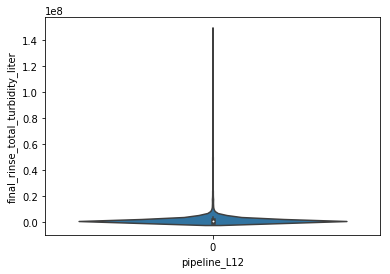

In [55]:
import seaborn as sns
sns.violinplot(x = 'pipeline_L12', y = 'final_rinse_total_turbidity_liter', data = train_features_w_response)

[Text(0, 0.5, 'final_rinse_total_turbidity_liter'),
 Text(0.5, 0, 'supply_pressure_max'),
 Text(0.5, 1.0, 'Title')]

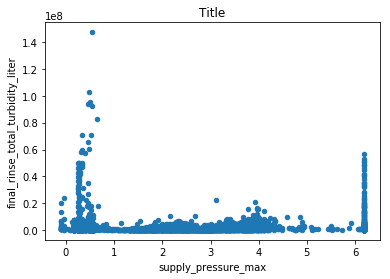

In [63]:
(train_features_w_response
 .plot
 .scatter(x='supply_pressure_max', y='final_rinse_total_turbidity_liter')
 .set(title='Title',
      xlabel='supply_pressure_max',
      ylabel='final_rinse_total_turbidity_liter'))

In [57]:
train_features_w_response.columns

Index(['pipeline_L1', 'pipeline_L10', 'pipeline_L11', 'pipeline_L12',
       'pipeline_L2', 'pipeline_L3', 'pipeline_L4', 'pipeline_L6',
       'pipeline_L7', 'pipeline_L8', 'pipeline_L9', 'num_phases',
       'process_duration', 'supply_flow_min', 'supply_flow_max',
       'supply_flow_mean', 'supply_flow_std', 'supply_flow_last_five_mean',
       'supply_pressure_min', 'supply_pressure_max', 'supply_pressure_mean',
       'supply_pressure_std', 'supply_pressure_last_five_mean',
       'return_temperature_min', 'return_temperature_max',
       'return_temperature_mean', 'return_temperature_std',
       'return_temperature_last_five_mean', 'return_conductivity_min',
       'return_conductivity_max', 'return_conductivity_mean',
       'return_conductivity_std', 'return_conductivity_last_five_mean',
       'return_turbidity_min', 'return_turbidity_max', 'return_turbidity_mean',
       'return_turbidity_std', 'return_turbidity_last_five_mean',
       'return_flow_min', 'return_flow_max', 